### Imports

In [ ]:
!pip install category-encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 821 kB/s 


## Download File

In [ ]:
!wget https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_KvRh9Sx.csv
!wget https://datahack-prod.s3.amazonaws.com/train_file/train_qWM28Yl.csv
!wget https://datahack-prod.s3.amazonaws.com/test_file/test_zo1G9sv.csv

--2022-11-13 13:03:24--  https://datahack-prod.s3.amazonaws.com/sample_submission/sample_submission_KvRh9Sx.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.160.79
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.160.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429713 (420K) [text/csv]
Saving to: ‘sample_submission_KvRh9Sx.csv’

sample_submission_K 100%[===================>] 419.64K   506KB/s    in 0.8s    

2022-11-13 13:03:25 (506 KB/s) - ‘sample_submission_KvRh9Sx.csv’ saved [429713/429713]

--2022-11-13 13:03:25--  https://datahack-prod.s3.amazonaws.com/train_file/train_qWM28Yl.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.156.163
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.156.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13820236 (13M) [text/csv]
Saving to: ‘tra

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
from xgboost import plot_importance,XGBClassifier
import category_encoders as ce
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [ ]:
def performance(true,pred):
  print('f1 score ',f1_score(true,pred))
  print('Precision ',precision_score(true,pred))
  print('Recall ',recall_score(true,pred))
  print('Accuracy ',accuracy_score(true,pred))
  print(confusion_matrix(true,pred))

### Load Data

In [ ]:
train = pd.read_csv('train_qWM28Yl.csv')
test = pd.read_csv('test_zo1G9sv.csv')
sub = pd.read_csv('sample_submission_KvRh9Sx.csv')

In [ ]:
train.shape,test.shape

((58592, 44), (39063, 43))

In [ ]:
train.isna().sum().sum(),test.isna().sum().sum()

(0, 0)

### Replace Yes/No with 1/0

In [ ]:
for col in test.columns:
  if col.startswith('is'):
    train[col].replace({'Yes':1,'No':0},inplace=True)
    test[col].replace({'Yes':1,'No':0},inplace=True)

In [ ]:
sum(train['is_claim'] == 1)/train.shape[0]

0.06396777717094485

### Check for Insights

In [ ]:
for col in test.columns:
  if train[col].nunique() < 50:
    tmp = pd.crosstab(train[col],train['is_claim']).reset_index()
    tmp['Total_Claim'] = tmp[0] + tmp[1]
    tmp['Total_Claim_Dist'] = 100*tmp['Total_Claim']/tmp['Total_Claim'].sum()
    tmp['claim_ratio'] = 100*tmp[1]/tmp['Total_Claim']
    tmp['claim_dist'] = 100*tmp[1]/tmp[1].sum()
    tmp['Non_Claim_dist'] = 100*tmp[0]/tmp[0].sum()
    display(tmp)
  else:
    try:
      tmp = train.groupby(['is_claim']).agg({col:'describe'}).reset_index()
      display(tmp)
    except:
      print(col)

is_claim policy_id                     
               count unique      top freq
0        0     54844  54844  ID00001    1
1        1      3748   3748  ID00013    1

is_claim policy_tenure                                                    \
                   count      mean       std       min       25%       50%   
0        0       54844.0  0.602720  0.414444  0.002735  0.199878  0.560953   
1        1        3748.0  0.736002  0.389169  0.002850  0.399630  0.833247   

                       
        75%       max  
0  1.035628  1.396641  
1  1.084144  1.335945

is_claim,age_of_car,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0.00,4698,559,5257,8.972215,10.633441,14.914621,8.566115
1,0.01,6067,295,6362,10.858138,4.636907,7.870864,11.062286
2,0.02,4876,313,5189,8.856158,6.031991,8.351121,8.890672
3,0.03,4143,272,4415,7.535158,6.160815,7.257204,7.554154
4,0.04,3515,248,3763,6.422378,6.590486,6.616862,6.409088
5,0.05,3116,226,3342,5.703850,6.762418,6.029883,5.681570
6,0.06,2847,206,3053,5.210609,6.747462,5.496265,5.191087
7,0.07,2682,206,2888,4.929001,7.132964,5.496265,4.890234
8,0.08,2556,174,2730,4.659339,6.373626,4.642476,4.660492
9,0.09,2476,167,2643,4.510855,6.318577,4.455710,4.514623


is_claim age_of_policyholder                                          \
                         count      mean       std       min       25%   
0        0             54844.0  0.468699  0.122628  0.288462  0.365385   
1        1              3748.0  0.479966  0.126140  0.288462  0.384615   

                                 
        50%       75%       max  
0  0.451923  0.548077  1.000000  
1  0.461538  0.557692  0.951923

is_claim,area_cluster,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,C1,1392,76,1468,2.505461,5.177112,2.027748,2.538108
1,C10,3007,148,3155,5.384694,4.690967,3.948773,5.482824
2,C11,1140,72,1212,2.068542,5.940594,1.921025,2.078623
3,C12,1502,87,1589,2.711974,5.475142,2.321238,2.738677
4,C13,3228,195,3423,5.842094,5.696757,5.202775,5.885785
5,C14,3379,281,3660,6.246587,7.677596,7.497332,6.161112
6,C15,733,38,771,1.315879,4.928664,1.013874,1.336518
7,C16,378,23,401,0.684394,5.735661,0.613661,0.689228
8,C17,473,19,492,0.839705,3.861789,0.506937,0.862446
9,C18,216,26,242,0.413026,10.743802,0.693703,0.393844


is_claim,population_density,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,290,733,38,771,1.315879,4.928664,1.013874,1.336518
1,3264,350,29,379,0.646846,7.651715,0.773746,0.638174
2,4076,5668,433,6101,10.412684,7.097197,11.552828,10.334768
3,4990,1392,76,1468,2.505461,5.177112,2.027748,2.538108
4,5410,3228,195,3423,5.842094,5.696757,5.202775,5.885785
5,6108,1140,72,1212,2.068542,5.940594,1.921025,2.078623
6,6112,2058,109,2167,3.698457,5.029995,2.908218,3.752462
7,7788,3379,281,3660,6.246587,7.677596,7.497332,6.161112
8,8794,12700,954,13654,23.303523,6.986964,25.453575,23.156590
9,13051,835,55,890,1.518979,6.179775,1.467449,1.522500


is_claim,make,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1,35671,2455,38126,65.070317,6.439175,65.501601,65.040843
1,2,2245,128,2373,4.050041,5.394016,3.415155,4.093429
2,3,13117,901,14018,23.924768,6.427450,24.039488,23.916928
3,4,1830,131,1961,3.346873,6.680265,3.495197,3.336737
4,5,1981,133,2114,3.608001,6.291391,3.548559,3.612063


is_claim,segment,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,A,16275,1046,17321,29.562056,6.038912,27.908218,29.675078
1,B1,3929,244,4173,7.122133,5.847112,6.510139,7.163956
2,B2,17058,1256,18314,31.256827,6.858141,33.511206,31.102764
3,C1,3329,228,3557,6.070795,6.409896,6.083244,6.069944
4,C2,13117,901,14018,23.924768,6.427450,24.039488,23.916928
5,Utility,1136,73,1209,2.063422,6.038048,1.947705,2.071330


is_claim,model,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,M1,14030,918,14948,25.512015,6.141290,24.493063,25.581650
1,M10,1136,73,1209,2.063422,6.038048,1.947705,2.071330
2,M11,348,15,363,0.619539,4.132231,0.400213,0.634527
3,M2,1000,80,1080,1.843255,7.407407,2.134472,1.823354
4,M3,2245,128,2373,4.050041,5.394016,3.415155,4.093429
5,M4,13117,901,14018,23.924768,6.427450,24.039488,23.916928
6,M5,1482,116,1598,2.727335,7.259074,3.094984,2.702210
7,M6,12837,939,13776,23.511742,6.816202,25.053362,23.406389
8,M7,2739,201,2940,5.017750,6.836735,5.362860,4.994165
9,M8,3929,244,4173,7.122133,5.847112,6.510139,7.163956


is_claim,fuel_type,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,CNG,19095,1235,20330,34.697570,6.074766,32.950907,34.816935
1,Diesel,16580,1150,17730,30.260104,6.486182,30.683031,30.231201
2,Petrol,19169,1363,20532,35.042327,6.638418,36.366062,34.951863


is_claim,max_torque,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,113Nm@4400rpm,16576,1220,17796,30.372747,6.855473,32.550694,30.223908
1,170Nm@4000rpm,348,15,363,0.619539,4.132231,0.400213,0.634527
2,200Nm@1750rpm,1981,133,2114,3.608001,6.291391,3.548559,3.612063
3,200Nm@3000rpm,1482,116,1598,2.727335,7.259074,3.094984,2.702210
4,250Nm@2750rpm,13117,901,14018,23.924768,6.427450,24.039488,23.916928
5,60Nm@3500rpm,14030,918,14948,25.512015,6.141290,24.493063,25.581650
6,82.1Nm@3400rpm,3929,244,4173,7.122133,5.847112,6.510139,7.163956
7,85Nm@3000rpm,1136,73,1209,2.063422,6.038048,1.947705,2.071330
8,91Nm@4250rpm,2245,128,2373,4.050041,5.394016,3.415155,4.093429


is_claim,max_power,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,113.45bhp@4000rpm,13117,901,14018,23.924768,6.427450,24.039488,23.916928
1,118.36bhp@5500rpm,348,15,363,0.619539,4.132231,0.400213,0.634527
2,40.36bhp@6000rpm,14030,918,14948,25.512015,6.141290,24.493063,25.581650
3,55.92bhp@5300rpm,3929,244,4173,7.122133,5.847112,6.510139,7.163956
4,61.68bhp@6000rpm,1136,73,1209,2.063422,6.038048,1.947705,2.071330
5,67.06bhp@5500rpm,2245,128,2373,4.050041,5.394016,3.415155,4.093429
6,88.50bhp@6000rpm,16576,1220,17796,30.372747,6.855473,32.550694,30.223908
7,88.77bhp@4000rpm,1482,116,1598,2.727335,7.259074,3.094984,2.702210
8,97.89bhp@3600rpm,1981,133,2114,3.608001,6.291391,3.548559,3.612063


is_claim,engine_type,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1.0 SCe,2245,128,2373,4.050041,5.394016,3.415155,4.093429
1,1.2 L K Series Engine,2739,201,2940,5.017750,6.836735,5.362860,4.994165
2,1.2 L K12N Dualjet,1000,80,1080,1.843255,7.407407,2.134472,1.823354
3,1.5 L U2 CRDi,13117,901,14018,23.924768,6.427450,24.039488,23.916928
4,1.5 Turbocharged Revotorq,1482,116,1598,2.727335,7.259074,3.094984,2.702210
5,1.5 Turbocharged Revotron,348,15,363,0.619539,4.132231,0.400213,0.634527
6,F8D Petrol Engine,14030,918,14948,25.512015,6.141290,24.493063,25.581650
7,G12B,1136,73,1209,2.063422,6.038048,1.947705,2.071330
8,K Series Dual jet,12837,939,13776,23.511742,6.816202,25.053362,23.406389
9,K10C,3929,244,4173,7.122133,5.847112,6.510139,7.163956


is_claim,airbags,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1,1136,73,1209,2.063422,6.038048,1.947705,2.071330
1,2,37852,2573,40425,68.994061,6.364873,68.649947,69.017577
2,6,15856,1102,16958,28.942518,6.498408,29.402348,28.911093


is_claim,is_esc,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,37640,2551,40191,68.594689,6.347192,68.062967,68.631026
1,1,17204,1197,18401,31.405311,6.505081,31.937033,31.368974


is_claim,is_adjustable_steering,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,21688,1378,23066,39.367149,5.974161,36.766275,39.544891
1,1,33156,2370,35526,60.632851,6.671170,63.233725,60.455109


is_claim,is_tpms,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,41727,2847,44574,76.075232,6.387132,75.960512,76.083072
1,1,13117,901,14018,23.924768,6.427450,24.039488,23.916928


is_claim,is_parking_sensors,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,2245,128,2373,4.050041,5.394016,3.415155,4.093429
1,1,52599,3620,56219,95.949959,6.439104,96.584845,95.906571


is_claim,is_parking_camera,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,33414,2290,35704,60.936647,6.413847,61.099253,60.925534
1,1,21430,1458,22888,39.063353,6.370150,38.900747,39.074466


is_claim,rear_brakes_type,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,Disc,13117,901,14018,23.924768,6.427450,24.039488,23.916928
1,Drum,41727,2847,44574,76.075232,6.387132,75.960512,76.083072


is_claim,displacement,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,796,14030,918,14948,25.512015,6.141290,24.493063,25.581650
1,998,3929,244,4173,7.122133,5.847112,6.510139,7.163956
2,999,2245,128,2373,4.050041,5.394016,3.415155,4.093429
3,1196,1136,73,1209,2.063422,6.038048,1.947705,2.071330
4,1197,16576,1220,17796,30.372747,6.855473,32.550694,30.223908
5,1199,348,15,363,0.619539,4.132231,0.400213,0.634527
6,1493,13117,901,14018,23.924768,6.427450,24.039488,23.916928
7,1497,1482,116,1598,2.727335,7.259074,3.094984,2.702210
8,1498,1981,133,2114,3.608001,6.291391,3.548559,3.612063


is_claim,cylinder,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,3,20552,1305,21857,37.303727,5.970627,34.81857,37.473561
1,4,34292,2443,36735,62.696273,6.650333,65.18143,62.526439


is_claim,transmission_type,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,Automatic,19101,1310,20411,34.835814,6.418108,34.951974,34.827875
1,Manual,35743,2438,38181,65.164186,6.385375,65.048026,65.172125


is_claim,gear_box,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,5,41379,2832,44211,75.455694,6.405646,75.560299,75.448545
1,6,13465,916,14381,24.544306,6.369515,24.439701,24.551455


is_claim,steering_type,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,Electric,22284,1597,23881,40.758124,6.687325,42.609392,40.631610
1,Manual,1136,73,1209,2.063422,6.038048,1.947705,2.071330
2,Power,31424,2078,33502,57.178454,6.202615,55.442903,57.297061


is_claim,turning_radius,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,4.50,1136,73,1209,2.063422,6.038048,1.947705,2.071330
1,4.60,14030,918,14948,25.512015,6.141290,24.493063,25.581650
2,4.70,3929,244,4173,7.122133,5.847112,6.510139,7.163956
3,4.80,13837,1019,14856,25.354997,6.859181,27.187834,25.229743
4,4.85,2739,201,2940,5.017750,6.836735,5.362860,4.994165
5,4.90,1981,133,2114,3.608001,6.291391,3.548559,3.612063
6,5.00,3727,244,3971,6.777376,6.144548,6.510139,6.795639
7,5.10,348,15,363,0.619539,4.132231,0.400213,0.634527
8,5.20,13117,901,14018,23.924768,6.427450,24.039488,23.916928


is_claim,length,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,3445,14030,918,14948,25.512015,6.141290,24.493063,25.581650
1,3655,3929,244,4173,7.122133,5.847112,6.510139,7.163956
2,3675,1136,73,1209,2.063422,6.038048,1.947705,2.071330
3,3731,2245,128,2373,4.050041,5.394016,3.415155,4.093429
4,3845,12837,939,13776,23.511742,6.816202,25.053362,23.406389
5,3990,4221,317,4538,7.745085,6.985456,8.457844,7.696375
6,3993,348,15,363,0.619539,4.132231,0.400213,0.634527
7,3995,2981,213,3194,5.451256,6.668754,5.683031,5.435417
8,4300,13117,901,14018,23.924768,6.427450,24.039488,23.916928


is_claim,width,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1475,1136,73,1209,2.063422,6.038048,1.947705,2.071330
1,1515,14030,918,14948,25.512015,6.141290,24.493063,25.581650
2,1579,2245,128,2373,4.050041,5.394016,3.415155,4.093429
3,1620,3929,244,4173,7.122133,5.847112,6.510139,7.163956
4,1695,1981,133,2114,3.608001,6.291391,3.548559,3.612063
5,1735,13837,1019,14856,25.354997,6.859181,27.187834,25.229743
6,1745,2739,201,2940,5.017750,6.836735,5.362860,4.994165
7,1755,1482,116,1598,2.727335,7.259074,3.094984,2.702210
8,1790,13117,901,14018,23.924768,6.427450,24.039488,23.916928
9,1811,348,15,363,0.619539,4.132231,0.400213,0.634527


is_claim,height,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1475,14030,918,14948,25.512015,6.141290,24.493063,25.581650
1,1490,2245,128,2373,4.050041,5.394016,3.415155,4.093429
2,1500,2739,201,2940,5.017750,6.836735,5.362860,4.994165
3,1501,1981,133,2114,3.608001,6.291391,3.548559,3.612063
4,1515,1000,80,1080,1.843255,7.407407,2.134472,1.823354
5,1523,1482,116,1598,2.727335,7.259074,3.094984,2.702210
6,1530,12837,939,13776,23.511742,6.816202,25.053362,23.406389
7,1606,348,15,363,0.619539,4.132231,0.400213,0.634527
8,1635,13117,901,14018,23.924768,6.427450,24.039488,23.916928
9,1675,3929,244,4173,7.122133,5.847112,6.510139,7.163956


is_claim,gross_weight,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,1051,1981,133,2114,3.608001,6.291391,3.548559,3.612063
1,1155,2245,128,2373,4.050041,5.394016,3.415155,4.093429
2,1185,14030,918,14948,25.512015,6.141290,24.493063,25.581650
3,1335,13837,1019,14856,25.354997,6.859181,27.187834,25.229743
4,1340,3929,244,4173,7.122133,5.847112,6.510139,7.163956
5,1410,2739,201,2940,5.017750,6.836735,5.362860,4.994165
6,1490,1482,116,1598,2.727335,7.259074,3.094984,2.702210
7,1510,1136,73,1209,2.063422,6.038048,1.947705,2.071330
8,1660,348,15,363,0.619539,4.132231,0.400213,0.634527
9,1720,13117,901,14018,23.924768,6.427450,24.039488,23.916928


is_claim,is_front_fog_lights,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,23170,1494,24664,42.094484,6.057412,39.861259,42.247101
1,1,31674,2254,33928,57.905516,6.643480,60.138741,57.752899


is_claim,is_rear_window_wiper,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,38988,2646,41634,71.057482,6.355383,70.597652,71.088907
1,1,15856,1102,16958,28.942518,6.498408,29.402348,28.911093


is_claim,is_rear_window_washer,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,38988,2646,41634,71.057482,6.355383,70.597652,71.088907
1,1,15856,1102,16958,28.942518,6.498408,29.402348,28.911093


is_claim,is_rear_window_defogger,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,35659,2418,38077,64.986688,6.350290,64.514408,65.018963
1,1,19185,1330,20515,35.013312,6.483061,35.485592,34.981037


is_claim,is_brake_assist,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,24803,1612,26415,45.082946,6.102593,43.009605,45.224637
1,1,30041,2136,32177,54.917054,6.638282,56.990395,54.775363


is_claim,is_power_door_locks,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,15166,991,16157,27.575437,6.133564,26.440768,27.652979
1,1,39678,2757,42435,72.424563,6.496995,73.559232,72.347021


is_claim,is_central_locking,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,15166,991,16157,27.575437,6.133564,26.440768,27.652979
1,1,39678,2757,42435,72.424563,6.496995,73.559232,72.347021


is_claim,is_power_steering,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,1136,73,1209,2.063422,6.038048,1.947705,2.07133
1,1,53708,3675,57383,97.936578,6.404336,98.052295,97.92867


is_claim,is_driver_seat_height_adjustable,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,22822,1479,24301,41.474945,6.086169,39.461046,41.612574
1,1,32022,2269,34291,58.525055,6.616897,60.538954,58.387426


is_claim,is_day_night_rear_view_mirror,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,34042,2267,36309,61.969211,6.243631,60.485592,62.0706
1,1,20802,1481,22283,38.030789,6.646322,39.514408,37.9294


is_claim,is_ecw,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,15166,991,16157,27.575437,6.133564,26.440768,27.652979
1,1,39678,2757,42435,72.424563,6.496995,73.559232,72.347021


is_claim,is_speed_alert,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,348,15,363,0.619539,4.132231,0.400213,0.634527
1,1,54496,3733,58229,99.380461,6.410895,99.599787,99.365473


is_claim,ncap_rating,0,1,Total_Claim,Total_Claim_Dist,claim_ratio,claim_dist,Non_Claim_dist
0,0,17905,1192,19097,32.593187,6.241818,31.803629,32.647145
1,2,20011,1391,21402,36.527171,6.499393,37.113127,36.487127
2,3,13117,901,14018,23.924768,6.427450,24.039488,23.916928
3,4,1981,133,2114,3.608001,6.291391,3.548559,3.612063
4,5,1830,131,1961,3.346873,6.680265,3.495197,3.336737


In [ ]:
train.shape,train['policy_id'].nunique(),train['policy_tenure'].nunique()

((58592, 44), 58592, 58592)

In [ ]:
test.shape,test['policy_tenure'].nunique()

((39063, 43), 39063)

## Feature Engineering

In [ ]:
train[['Nm','rpm_torque']] = train['max_torque'].str.split('@',expand=True)
test[['Nm','rpm_torque']] = test['max_torque'].str.split('@',expand=True)

train['Nm'] = train['Nm'].apply(lambda x: float(x[:-2]))
test['Nm'] = test['Nm'].apply(lambda x: float(x[:-2]))

train['rpm_torque'] = train['rpm_torque'].apply(lambda x: float(x[:-3]))
test['rpm_torque'] = test['rpm_torque'].apply(lambda x: float(x[:-3]))

train[['bhp','rpm_power']] = train['max_power'].str.split('@',expand=True)
test[['bhp','rpm_power']] = test['max_power'].str.split('@',expand=True)

train['bhp'] = train['bhp'].apply(lambda x: float(x[:-3]))
test['bhp'] = test['bhp'].apply(lambda x: float(x[:-3]))

train['rpm_power'] = train['rpm_power'].apply(lambda x: float(x[:-3]))
test['rpm_power'] = test['rpm_power'].apply(lambda x: float(x[:-3]))

In [ ]:
for i in [train,test]:
  i['weight_per_area'] = i['gross_weight']/(i['length']*i['width']*i['height'])
  i['Nm_rpm'] = i['rpm_torque']/i['Nm']
  i['bhp_rpm'] = i['rpm_power']/i['bhp']
  i['age'] = (i['age_of_car']/i['age_of_policyholder'])

### Preparation for Modelling

In [ ]:
num_col = ['policy_tenure','age',#'age_of_car', 'age_of_policyholder',
        'population_density', 'make',   'airbags','is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera',
        'displacement', 'cylinder',
          'turning_radius',
       'is_front_fog_lights',
       'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert',  'weight_per_area','Nm_rpm','bhp_rpm']

cat_col = ['area_cluster','segment', 'model',
       'fuel_type','engine_type',
       'rear_brakes_type','transmission_type','steering_type','gear_box','ncap_rating']

In [ ]:
X=train[num_col + cat_col]
y=train['is_claim']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)


In [ ]:
ce_target = ce.TargetEncoder(cols=cat_col)
X_train_encoded = ce_target.fit_transform(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [ ]:
std = StandardScaler()
X_train_encoded = std.fit_transform(X_train_encoded)
X_train_encoded = pd.DataFrame(X_train_encoded,columns = X_train.columns)

### XGBoost

In [ ]:
scale_pos_weight = sum(y == 0)/sum(y == 1) 
print('Scale Pos Weight : ', scale_pos_weight)

Scale Pos Weight :  14.632870864461045


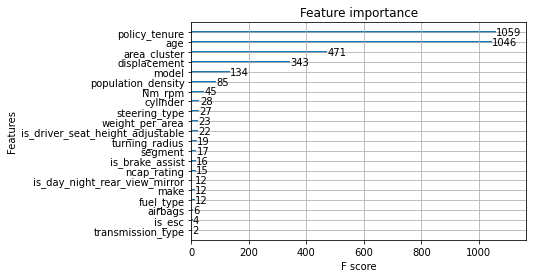

In [ ]:
model = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,
                                    scale_pos_weight=round(scale_pos_weight))
model.fit(X_train_encoded, y_train)

plot_importance(model)

In [ ]:
y_pred_train = model.predict(X_train_encoded)
y_pred_train_prob = model.predict_proba(X_train_encoded)[:,1]
print('Train ')
performance(y_train,y_pred_train_prob>=0.6)
print('Test ')
X_test_encoded = ce_target.transform(X_test)
X_test_encoded = std.transform(X_test_encoded)
X_test_encoded = pd.DataFrame(X_test_encoded,columns = X_test.columns)
y_pred_test = model.predict(X_test_encoded)
y_pred_test_prob = model.predict_proba(X_test_encoded)[:,1]
performance(y_test,y_pred_test_prob >= 0.6)

Train 
f1 score  0.18274950429610046
Precision  0.11901431184762724
Recall  0.3934542867307008
Accuracy  0.7748953213180412
[[32946  8187]
 [ 1705  1106]]
Test 
f1 score  0.16751391914790612
Precision  0.10832811521603006
Recall  0.36926360725720386
Accuracy  0.7652239213544512
[[10863  2848]
 [  591   346]]


In [ ]:
test_encoded = ce_target.transform(test[num_col+cat_col])
test_encoded = std.transform(test_encoded)
test_encoded = pd.DataFrame(test_encoded,columns=X.columns)
test['prob'] = model.predict_proba(test_encoded)[:,1]
test['is_claim'] = np.where(test['prob'] > 0.6,1,0)
test[['policy_id','is_claim']].to_csv('sub_3.csv',index=0)

## Train on Complete Data for Submission

In [ ]:
ce_all = ce.TargetEncoder(cols=cat_col)
X_encoded = ce_all.fit_transform(X, y)
std_all = StandardScaler()
X_encoded = std_all.fit_transform(X_encoded)
X_encoded = pd.DataFrame(X_encoded,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


Train 
f1 score  0.16710072073163348
Precision  0.09424745507959281
Recall  0.7361259338313767
Accuracy  0.530584380120153
[[28329 26515]
 [  989  2759]]


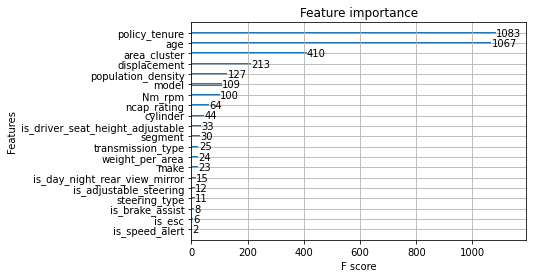

In [ ]:
model_all = XGBClassifier(gamma=5, learning_rate=0.01, n_estimators=500, random_state=42,max_depth=3,
                                    scale_pos_weight=round(scale_pos_weight))
model_all.fit(X_encoded, y)
y_pred = model_all.predict(X_encoded)
print('Train ')
performance(y,y_pred)
plot_importance(model_all)

### Check for Optimal Threshold

In [ ]:
y_pred_prob = model.predict_proba(X_encoded)[:,1]
for i in [j/100 for j in range(59,70)]:
  print(i,'-'*10)
  performance(y,y_pred_prob > i)

0.59 ----------
f1 score  0.18100724772347146
Precision  0.11787010891488503
Recall  0.38980789754535755
Accuracy  0.7743548607318406
[[43910 10934]
 [ 2287  1461]]
0.6 ----------
f1 score  0.17894663605371183
Precision  0.12103529411764706
Recall  0.3431163287086446
Accuracy  0.7985902512288368
[[45505  9339]
 [ 2462  1286]]
0.61 ----------
f1 score  0.17469348505489224
Precision  0.12484251517581033
Recall  0.29082177161152617
Accuracy  0.8242251501911524
[[47203  7641]
 [ 2658  1090]]
0.62 ----------
f1 score  0.16934893928310166
Precision  0.1288258208124652
Recall  0.24706510138740662
Accuracy  0.8449617695248498
[[48582  6262]
 [ 2822   926]]
0.63 ----------
f1 score  0.16249593760155998
Precision  0.13678643078606603
Recall  0.2001067235859125
Accuracy  0.8680536592026216
[[50111  4733]
 [ 2998   750]]
0.64 ----------
f1 score  0.14686988285678299
Precision  0.13910761154855644
Recall  0.1555496264674493
Accuracy  0.8844040141998908
[[51236  3608]
 [ 3165   583]]
0.65 ----------

### Submission

In [ ]:
test_encoded = ce_all.transform(test[num_col+cat_col])
test_encoded = std_all.transform(test_encoded)
test_encoded = pd.DataFrame(test_encoded,columns=X.columns)
test['prob'] = model_all.predict_proba(test_encoded)[:,1]
test['is_claim'] = np.where(test['prob'] >= 0.6,1,0)
test[['policy_id','is_claim']].to_csv('sub_3_all.csv',index=0)